# Data301 Project
# Grey Harris
# 97774899
Summary To what extent has there been a change in confidence between political leaders and types of news due to SARS-CoV-2. The subset of GDELT data that will be used to answer this question is the Event table with Actor1Name, Actor1CountryCode and EventCode as the columns. Market basket analysis including A-priori algorithm will be used and the intended result will return the actor and event tuple with confidence for each record this will include all countries and those specifically defined in the rules below. The data will be within the date ranges 31/08/19 - 30/12/19 for pre SARS-CoV-2 and 31/12/19 - 31/04/20 for post SARS-CoV-2. This result will allow me to make a simple comparison between the two date ranges and in turn answer the question.



# New Section

## Setup libraries/imports

In [ ]:
#library and code setup
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!pip install -q pyspark
import pyspark, os
from pyspark import SparkConf, SparkContext
os.environ["PYSPARK_PYTHON"]="python3"
os.environ["JAVA_HOME"]="/usr/lib/jvm/java-8-openjdk-amd64/"

!pip install gdelt

In [ ]:
!wget http://data.gdeltproject.org/supportingdatasets/DOMAINSBYCOUNTRY-ENGLISH.TXT
from concurrent.futures import ProcessPoolExecutor
from datetime import date, timedelta
import pandas as pd
import gdelt
import os

--2020-06-01 11:19:06--  http://data.gdeltproject.org/supportingdatasets/DOMAINSBYCOUNTRY-ENGLISH.TXT
Resolving data.gdeltproject.org (data.gdeltproject.org)... 74.125.203.128, 2404:6800:4008:c03::80
Connecting to data.gdeltproject.org (data.gdeltproject.org)|74.125.203.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 426990 (417K) [text/plain]
Saving to: ‘DOMAINSBYCOUNTRY-ENGLISH.TXT.31’

DOMAINSBYCOUNTRY-EN 100%[===================>] 416.98K  --.-KB/s    in 0.002s  

2020-06-01 11:19:06 (179 MB/s) - ‘DOMAINSBYCOUNTRY-ENGLISH.TXT.31’ saved [426990/426990]



In [ ]:
import sys, os
from operator import add
import time

os.environ["PYSPARK_PYTHON"]="python3"

import pyspark
from pyspark import SparkConf, SparkContext

try:
  conf = SparkConf().setMaster("local[*]").set("spark.executor.memory", "1g") 
  sc = SparkContext(conf = conf)
except ValueError:
  pass

def dbg(x):
  """ A helper function to print debugging information on RDDs """
  if isinstance(x, pyspark.RDD):
    print([(t[0], list(t[1]) if 
            isinstance(t[1], pyspark.resultiterable.ResultIterable) else t[1])
           if isinstance(t, tuple) else t
           for t in x.take(100)])
  else:
    print(x)

In [ ]:
# these remove files from previous runs - retrived from Sample GDELT starter only.ipynb "Written by James Atlas"
!rm -rf articles
!rm *.csv

# Pull Data


In [ ]:
# set up gdeltpyr for version 2
gd = gdelt.gdelt(version=2)

# multiprocess the query
e = ProcessPoolExecutor()

# generic functions to pull and write data to disk based on date
def get_filename(x):
  date = x.strftime('%Y%m%d')
  return "{}_gdeltdata.csv".format(date)

def intofile(filename):
    try:
        if not os.path.exists(filename):
          date = filename.split("_")[0]
          d = gd.Search([date], table='gkg',coverage=False) #Toggle 15 min updates
          d.to_csv(filename,encoding='utf-8',index=False)
    except:
        print("Error occurred")

#daterange = sc.parallelize(pd.date_range('2020 Apr 01','2020 Apr 30'))
#daterange = sc.parallelize(pd.date_range('2020 May 01','2020 May 30'))
#daterange = sc.parallelize(pd.date_range('2020 Feb 01','2020 Feb 30'))
daterange = sc.parallelize(pd.date_range('2020 Jan 01','2020 Jan 30'))

#daterange = sc.parallelize(pd.date_range('2020 Feb 01','2020 May 30'))

dates = daterange.map(get_filename)
dates.foreach(intofile)

# Clean and sort data

In [ ]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)
alist = dates.collect()

for i in alist:
    try:
        sqlContext.read.option("header", "true").csv(i)
    except:
        alist.remove(i)

data = sqlContext.read.option("header", "true").csv(alist)

dbg(data)

Select_Cols = ['SourceCommonName', 'DATE', 'Themes', 'V2Themes', 'V2Locations']
GKG_data_selected = data.select([column for column in data.columns if column in Select_Cols])
GKG_data_cleaned = GKG_data_selected.na.drop()

dbg(GKG_data_cleaned)
GKG_data_cleaned.show(10)
pandas_data_cleaned = GKG_data_cleaned.toPandas()

DataFrame[GKGRECORDID: string, DATE: string, SourceCollectionIdentifier: string, SourceCommonName: string, DocumentIdentifier: string, Counts: string, V2Counts: string, Themes: string, V2Themes: string, Locations: string, V2Locations: string, Persons: string, V2Persons: string, Organizations: string, V2Organizations: string, V2Tone: string, Dates: string, GCAM: string, SharingImage: string, RelatedImages: string, SocialImageEmbeds: string, SocialVideoEmbeds: string, Quotations: string, AllNames: string, Amounts: string, TranslationInfo: string, Extras: string]
DataFrame[DATE: string, SourceCommonName: string, Themes: string, V2Themes: string, V2Locations: string]
+--------------+------------------+--------------------+--------------------+--------------------+
|          DATE|  SourceCommonName|              Themes|            V2Themes|         V2Locations|
+--------------+------------------+--------------------+--------------------+--------------------+
|20200116234500|  freerepublic.

Clean/split themes

In [ ]:
def clean_themes(x):
    """Splits themes, written by cameron bodger"""
    if x[0] is not None:
        country = sources.value.get(x[0])
    else:
        country = None
    if x[1] is not None:
        themes = x[1].split(';')
        themes_list = [theme.split(',')[0] for theme in themes]
    else:
        themes = None
    if x[2] is not None:
        locations = re.split(",|#|;", x[2])
    else:
        locations = None
    if x[3] is not None:
        orgs = re.split(",|#|;", x[3])
        orgs = [o.lower() for o in orgs if not o.isnumeric()]
    else:
        orgs = None
    return country, themes_list, locations, orgs, x[4]


In [ ]:
# CODE ADAPTED FROM CAMERON BODGER 78992602

file = "DOMAINSBYCOUNTRY-ENGLISH.TXT"
def process_source_country(file):
    source_dict = {}
    with open(file) as f:
        lines = f.readlines()
        for line in lines:
            try:
                source, code, country = line.split(None, maxsplit=2)
                source_dict[source] = code
            except ValueError:  
                source, code = line.split(None, maxsplit=1)
                source_dict[source] = code
    return source_dict

source_country_dict = process_source_country(file)
sources = sc.broadcast(source_country_dict)


Functions to calculate themes and countries

In [ ]:
#theme_list = ['ECONOMY', 'TRAVEL', 'SPORT', 'POLITICAL', 'JOBS', 'HEALTH', 'HOUSING']

def calculate_theme_scalable(x, themes):
    """Checks for themes and works out what is mentioned"""
    tally = 0
    theme_list = [0] * len(themes)
    for i in range(len(themes)):
      if themes[i] in x:
        theme_list[i] = 1
        tally += 1
    if tally == 0:
      return None
    else:
      for i in range(len(theme_list)):
        theme_list[i] = theme_list[i] / tally
      return theme_list

def define_country(x):
    """takes SourceCommonName, returns the associated country value"""
    if x in sources.value:
      return sources.value[x]


In [ ]:
pandas_data_cleaned = GKG_data_cleaned.toPandas() #changes the dataframe to a pandas dataframe

pandas_data_cleaned['Country'] = pandas_data_cleaned['SourceCommonName'].apply(lambda x: define_country(x)) #make a new column called Country send through the URL to the define country function and 
pandas_data_cleaned #show the table

,DATE,SourceCommonName,Themes,V2Themes,V2Locations,Country
0,20200116234500,freerepublic.com,TAX_ETHNICITY;TAX_ETHNICITY_RUSSIAN;TAX_WORLDL...,"TAX_FNCACT_CHAIRWOMAN,282;TAX_FNCACT_REPRESENT...","2#Florida, United States#US#USFL##27.8333#-81....",US
1,20200116234500,jazzfm.com,TAX_ETHNICITY;TAX_ETHNICITY_AMERICAN;TAX_FNCAC...,"TAX_FNCACT_DANCER,64;TAX_FNCACT_SINGER,32;TAX_...","2#California, United States#US#USCA##36.17#-11...",None
2,20200116234500,wcjb.com,TRIAL;TAX_FNCACT;TAX_FNCACT_PROSECUTORS;SOC_GE...,"KILL,565;TAX_FNCACT_ATTORNEY,234;WB_1331_HEALT...","3#Milwaukee, Wisconsin, United States#US#USWI#...",US
3,20200116234500,bnnbloomberg.ca,KILL;CRISISLEX_T03_DEAD;TAX_DISEASE;TAX_DISEAS...,"MEDIA_MSM,1601;TAX_DISEASE_PNEUMONIA,134;TAX_D...","4#Wuhan, Hubei, China#CH#CH12#13124#30.5833#11...",None
4,20200116234500,comicbook.com,TAX_WORLDLANGUAGES;TAX_WORLDLANGUAGES_MANGA;MA...,"KILL,2082;TAX_WORLDMAMMALS_HUMAN,2207;TAX_WORL...",1#Japan#JA#JA##36#138#JA#564,US
...,...,...,...,...,...,...
36121,20200104234500,dissidentvoice.org,TAX_FNCACT;TAX_FNCACT_MAN;MANMADE_DISASTER_IMP...,"MANMADE_DISASTER_IMPLIED,574;MANMADE_DISASTER_...",1#Russia#RS#RS##60#100#RS#2894;1#Russia#RS#RS#...,US
36122,20200104234500,tribuneonlineng.com,TAX_FNCACT;TAX_FNCACT_DEPUTY;LEADER;TAX_FNCACT...,"GENERAL_GOVERNMENT,410;GENERAL_GOVERNMENT,489;...","4#Nupe, Nigeria (General), Nigeria#NI#NI00#191...",None
36123,20200104234500,5newsonline.com,PROTEST;ARMEDCONFLICT;EPU_CATS_NATIONAL_SECURI...,"KILL,1064;EDUCATION,999;TAX_FNCACT_PROFESSOR,9...","1#Russia#RS#RS##60#100#RS#478;2#Arkansas, Unit...",US
36124,20200104234500,chesterstandard.co.uk,TAX_FNCACT;TAX_FNCACT_DRIVERS;KILL;CRISISLEX_T...,"TRAFFIC,1189;AFFECT,1181;WB_168_ROADS_AND_HIGH...","4#Bedfordshire, United Kingdom (General), Unit...",None


Drop none/naan rows

In [ ]:
pandas_data_cleaned.dropna(inplace=True)
pandas_data_cleaned

,DATE,SourceCommonName,Themes,V2Themes,V2Locations,Country
0,20200116234500,freerepublic.com,TAX_ETHNICITY;TAX_ETHNICITY_RUSSIAN;TAX_WORLDL...,"TAX_FNCACT_CHAIRWOMAN,282;TAX_FNCACT_REPRESENT...","2#Florida, United States#US#USFL##27.8333#-81....",US
2,20200116234500,wcjb.com,TRIAL;TAX_FNCACT;TAX_FNCACT_PROSECUTORS;SOC_GE...,"KILL,565;TAX_FNCACT_ATTORNEY,234;WB_1331_HEALT...","3#Milwaukee, Wisconsin, United States#US#USWI#...",US
4,20200116234500,comicbook.com,TAX_WORLDLANGUAGES;TAX_WORLDLANGUAGES_MANGA;MA...,"KILL,2082;TAX_WORLDMAMMALS_HUMAN,2207;TAX_WORL...",1#Japan#JA#JA##36#138#JA#564,US
6,20200116234500,clickondetroit.com,BORDER;CRISISLEX_C07_SAFETY;SOC_USSECURITYAGEN...,"EPU_POLICY_GOVERNMENT,2639;MEDIA_MSM,492;CRISI...",1#Mexico#MX#MX##23#-102#MX#876;1#Mexico#MX#MX#...,US
7,20200116234500,ktbs.com,TAX_DISEASE;TAX_DISEASE_DIABETES;TAX_CHRONICDI...,"TAX_DISEASE_GLAUCOMA,2153;TAX_DISEASE_GLAUCOMA...",1#Americans#US#US##39.828175#-98.5795#US#1561;...,US
...,...,...,...,...,...,...
36117,20200104234500,stltoday.com,RELIGION;WB_696_PUBLIC_SECTOR_MANAGEMENT;WB_20...,"TAX_ETHNICITY_GERMAN,1066;TAX_WORLDLANGUAGES_G...",1#Italian#IT#IT##42.833333#12.833333#IT#1076;1...,US
36118,20200104234500,mirror.co.uk,CRISISLEX_T11_UPDATESSYMPATHY;TAX_ETHNICITY;TA...,"KILL,364;KILL,2318;KIDNAP,1389;CRISISLEX_CRISI...",1#Americans#US#US##39.828175#-98.5795#US#1295;...,UK
36121,20200104234500,dissidentvoice.org,TAX_FNCACT;TAX_FNCACT_MAN;MANMADE_DISASTER_IMP...,"MANMADE_DISASTER_IMPLIED,574;MANMADE_DISASTER_...",1#Russia#RS#RS##60#100#RS#2894;1#Russia#RS#RS#...,US
36123,20200104234500,5newsonline.com,PROTEST;ARMEDCONFLICT;EPU_CATS_NATIONAL_SECURI...,"KILL,1064;EDUCATION,999;TAX_FNCACT_PROFESSOR,9...","1#Russia#RS#RS##60#100#RS#478;2#Arkansas, Unit...",US


Function to check for themes present in articles

In [ ]:
#ECONOMY
#TRAVEL
#SPORT

def calculate_themes(x):
    """Checks for themes and works out what is mentioned"""
    # [ECONOMY, TRAVEL, SPORT]
    tally = 0
    theme_list = [0] * 3
    if 'ECONOMY' in x:
      theme_list[0] = 1
      tally += 1
    if 'TRAVEL' in x:
      theme_list[1] = 1
      tally += 1
    if 'SPORT' in x:
      theme_list[2] = 1
      tally += 1
    if tally == 0:
      return None
    else:
      for i in range(len(theme_list)):
        theme_list[i] = theme_list[i] / tally
      return theme_list


#theme_list = ['ECONOMY', 'TRAVEL', 'SPORT', 'POLITICAL', 'JOBS', 'HEALTH', 'HOUSING']
theme_list = ['ECONOMY', 'HEALTH']

def add_themes(frame, theme_list):
    """for each theme in list add new column to frame containing 0's"""
    for theme in theme_list:
      frame[theme] = 0
    frame['COUNT'] = 0

def check_theme(themes, theme):
    """Checks if 'theme' in themes and adds it to table"""
    if theme in themes:
      return 1
    else:
      return 0

pandas_data_cleaned

,DATE,SourceCommonName,Themes,V2Themes,V2Locations,Country
0,20200116234500,freerepublic.com,TAX_ETHNICITY;TAX_ETHNICITY_RUSSIAN;TAX_WORLDL...,"TAX_FNCACT_CHAIRWOMAN,282;TAX_FNCACT_REPRESENT...","2#Florida, United States#US#USFL##27.8333#-81....",US
2,20200116234500,wcjb.com,TRIAL;TAX_FNCACT;TAX_FNCACT_PROSECUTORS;SOC_GE...,"KILL,565;TAX_FNCACT_ATTORNEY,234;WB_1331_HEALT...","3#Milwaukee, Wisconsin, United States#US#USWI#...",US
4,20200116234500,comicbook.com,TAX_WORLDLANGUAGES;TAX_WORLDLANGUAGES_MANGA;MA...,"KILL,2082;TAX_WORLDMAMMALS_HUMAN,2207;TAX_WORL...",1#Japan#JA#JA##36#138#JA#564,US
6,20200116234500,clickondetroit.com,BORDER;CRISISLEX_C07_SAFETY;SOC_USSECURITYAGEN...,"EPU_POLICY_GOVERNMENT,2639;MEDIA_MSM,492;CRISI...",1#Mexico#MX#MX##23#-102#MX#876;1#Mexico#MX#MX#...,US
7,20200116234500,ktbs.com,TAX_DISEASE;TAX_DISEASE_DIABETES;TAX_CHRONICDI...,"TAX_DISEASE_GLAUCOMA,2153;TAX_DISEASE_GLAUCOMA...",1#Americans#US#US##39.828175#-98.5795#US#1561;...,US
...,...,...,...,...,...,...
36117,20200104234500,stltoday.com,RELIGION;WB_696_PUBLIC_SECTOR_MANAGEMENT;WB_20...,"TAX_ETHNICITY_GERMAN,1066;TAX_WORLDLANGUAGES_G...",1#Italian#IT#IT##42.833333#12.833333#IT#1076;1...,US
36118,20200104234500,mirror.co.uk,CRISISLEX_T11_UPDATESSYMPATHY;TAX_ETHNICITY;TA...,"KILL,364;KILL,2318;KIDNAP,1389;CRISISLEX_CRISI...",1#Americans#US#US##39.828175#-98.5795#US#1295;...,UK
36121,20200104234500,dissidentvoice.org,TAX_FNCACT;TAX_FNCACT_MAN;MANMADE_DISASTER_IMP...,"MANMADE_DISASTER_IMPLIED,574;MANMADE_DISASTER_...",1#Russia#RS#RS##60#100#RS#2894;1#Russia#RS#RS#...,US
36123,20200104234500,5newsonline.com,PROTEST;ARMEDCONFLICT;EPU_CATS_NATIONAL_SECURI...,"KILL,1064;EDUCATION,999;TAX_FNCACT_PROFESSOR,9...","1#Russia#RS#RS##60#100#RS#478;2#Arkansas, Unit...",US


Record which themes are mentioned in articles and discard articles with no health/economy themes

In [ ]:
#pandas_data_cleaned.insert(lambda themes['V2Themes']: check_theme(themes, 'HEALTH'))
pandas_data_cleaned['HEALTH'] = pandas_data_cleaned.apply(lambda themes: check_theme(themes['V2Themes'], 'HEALTH'), axis = 1)
pandas_data_cleaned['ECONOMY'] = pandas_data_cleaned.apply(lambda themes: check_theme(themes['V2Themes'], 'ECONOMY'), axis = 1)
pandas_data_cleaned.dropna(inplace=True)
pandas_data_cleaned

,DATE,SourceCommonName,Themes,V2Themes,V2Locations,Country,HEALTH,ECONOMY
0,20200116234500,freerepublic.com,TAX_ETHNICITY;TAX_ETHNICITY_RUSSIAN;TAX_WORLDL...,"TAX_FNCACT_CHAIRWOMAN,282;TAX_FNCACT_REPRESENT...","2#Florida, United States#US#USFL##27.8333#-81....",US,0,0
2,20200116234500,wcjb.com,TRIAL;TAX_FNCACT;TAX_FNCACT_PROSECUTORS;SOC_GE...,"KILL,565;TAX_FNCACT_ATTORNEY,234;WB_1331_HEALT...","3#Milwaukee, Wisconsin, United States#US#USWI#...",US,1,0
4,20200116234500,comicbook.com,TAX_WORLDLANGUAGES;TAX_WORLDLANGUAGES_MANGA;MA...,"KILL,2082;TAX_WORLDMAMMALS_HUMAN,2207;TAX_WORL...",1#Japan#JA#JA##36#138#JA#564,US,0,0
6,20200116234500,clickondetroit.com,BORDER;CRISISLEX_C07_SAFETY;SOC_USSECURITYAGEN...,"EPU_POLICY_GOVERNMENT,2639;MEDIA_MSM,492;CRISI...",1#Mexico#MX#MX##23#-102#MX#876;1#Mexico#MX#MX#...,US,1,0
7,20200116234500,ktbs.com,TAX_DISEASE;TAX_DISEASE_DIABETES;TAX_CHRONICDI...,"TAX_DISEASE_GLAUCOMA,2153;TAX_DISEASE_GLAUCOMA...",1#Americans#US#US##39.828175#-98.5795#US#1561;...,US,1,0
...,...,...,...,...,...,...,...,...
36117,20200104234500,stltoday.com,RELIGION;WB_696_PUBLIC_SECTOR_MANAGEMENT;WB_20...,"TAX_ETHNICITY_GERMAN,1066;TAX_WORLDLANGUAGES_G...",1#Italian#IT#IT##42.833333#12.833333#IT#1076;1...,US,1,1
36118,20200104234500,mirror.co.uk,CRISISLEX_T11_UPDATESSYMPATHY;TAX_ETHNICITY;TA...,"KILL,364;KILL,2318;KIDNAP,1389;CRISISLEX_CRISI...",1#Americans#US#US##39.828175#-98.5795#US#1295;...,UK,0,0
36121,20200104234500,dissidentvoice.org,TAX_FNCACT;TAX_FNCACT_MAN;MANMADE_DISASTER_IMP...,"MANMADE_DISASTER_IMPLIED,574;MANMADE_DISASTER_...",1#Russia#RS#RS##60#100#RS#2894;1#Russia#RS#RS#...,US,0,0
36123,20200104234500,5newsonline.com,PROTEST;ARMEDCONFLICT;EPU_CATS_NATIONAL_SECURI...,"KILL,1064;EDUCATION,999;TAX_FNCACT_PROFESSOR,9...","1#Russia#RS#RS##60#100#RS#478;2#Arkansas, Unit...",US,0,0


Reduce table to countries health and economy

In [ ]:
country_econ_health = pandas_data_cleaned.groupby('Country').sum()[['HEALTH','ECONOMY']].reset_index()
print(country_econ_health)

   Country  HEALTH  ECONOMY
0       AE       5        9
1       AF       3       10
2       AJ       5        0
3       AM       0        0
4       AS     412      216
..     ...     ...      ...
76      WI       0        0
77      WZ       4        2
78      YM       1        0
79      ZA       0        1
80      ZI      36       51

[81 rows x 3 columns]


Calculate how many records for each country

In [ ]:
country_econ_health['SUM'] = country_econ_health.HEALTH + country_econ_health.ECONOMY
print(country_econ_health)

   Country  HEALTH  ECONOMY  SUM
0       AE       5        9   14
1       AF       3       10   13
2       AJ       5        0    5
3       AM       0        0    0
4       AS     412      216  628
..     ...     ...      ...  ...
76      WI       0        0    0
77      WZ       4        2    6
78      YM       1        0    1
79      ZA       0        1    1
80      ZI      36       51   87

[81 rows x 4 columns]


In [ ]:
country_econ_health['HEALTH'] = country_econ_health.HEALTH / country_econ_health.SUM
country_econ_health['ECONOMY'] = country_econ_health.ECONOMY / country_econ_health.SUM
print(country_econ_health)

   Country    HEALTH   ECONOMY  SUM
0       AE  0.357143  0.642857   14
1       AF  0.230769  0.769231   13
2       AJ  1.000000  0.000000    5
3       AM       NaN       NaN    0
4       AS  0.656051  0.343949  628
..     ...       ...       ...  ...
76      WI       NaN       NaN    0
77      WZ  0.666667  0.333333    6
78      YM  1.000000  0.000000    1
79      ZA  0.000000  1.000000    1
80      ZI  0.413793  0.586207   87

[81 rows x 4 columns]


Remove countries with to few records

In [ ]:
final_table = country_econ_health[country_econ_health.SUM > 40].copy() 
final_table

,Country,HEALTH,ECONOMY,SUM
4,AS,0.656051,0.343949,628
15,CA,0.585470,0.414530,936
17,CE,0.377358,0.622642,53
18,CH,0.432432,0.567568,148
32,IN,0.566434,0.433566,286
34,IS,0.632353,0.367647,68
36,JA,0.411765,0.588235,68
48,MY,0.537736,0.462264,106
49,NI,0.453488,0.546512,172
51,NZ,0.511111,0.488889,180


# Run k-means


Adaption of k means algorithm from blog https://benalexkeen.com/k-means-clustering-in-python/

Basic k means iteration


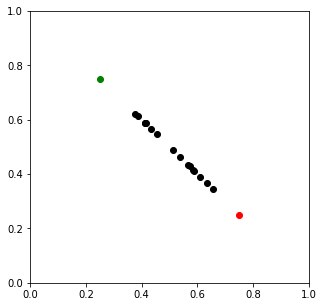

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(200)
k = 2
#centroids = {i: random.uniform(0.2, 0.8) for i in range(k)} random centeroids
centroids = {}
centroids[0] = 0.75
centroids[1] = 0.25

fig = plt.figure(figsize=(5, 5))
plt.scatter(final_table['HEALTH'], final_table['ECONOMY'], color='k')
colmap = {0: 'r', 1: 'g', 2: 'b'}
for i in centroids.keys():
    plt.scatter(centroids[i], 1 - centroids[i],  color=colmap[i])
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.show()

In [ ]:
for i in range(k):
    final_table[f'k{i}'] = np.zeros(len(final_table))

Cluster values around centeroids

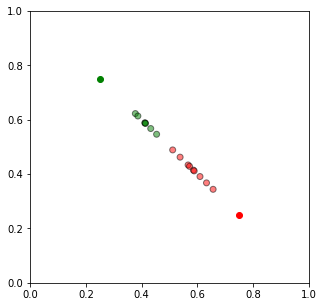

   Country    HEALTH   ECONOMY  ...  distance_from_1  closest  color
4       AS  0.656051  0.343949  ...         0.574243        0      r
15      CA  0.585470  0.414530  ...         0.474426        0      r
17      CE  0.377358  0.622642  ...         0.180112        1      g
18      CH  0.432432  0.567568  ...         0.257998        1      g
32      IN  0.566434  0.433566  ...         0.447505        0      r
34      IS  0.632353  0.367647  ...         0.540729        0      r
36      JA  0.411765  0.588235  ...         0.228770        1      g
48      MY  0.537736  0.462264  ...         0.406920        0      r
49      NI  0.453488  0.546512  ...         0.287776        1      g
51      NZ  0.511111  0.488889  ...         0.369267        0      r
52      PK  0.588235  0.411765  ...         0.478337        0      r
60      SF  0.386364  0.613636  ...         0.192847        1      g
67      TH  0.411765  0.588235  ...         0.228770        1      g
72      UK  0.609040  0.390960  ..

In [ ]:
def assignment(final_table, centroids):
    for i in centroids.keys():
        final_table['distance_from_{}'.format(i)] = (
            np.sqrt(
                (final_table['HEALTH'] - centroids[i]) ** 2
                + (final_table['ECONOMY'] - (1 - centroids[i])) ** 2
            )
        )
    centroid_distance_cols = ['distance_from_{}'.format(i) for i in centroids.keys()]
    final_table['closest'] = final_table.loc[:, centroid_distance_cols].idxmin(axis=1)
    final_table['closest'] = final_table['closest'].map(lambda x: int(x.lstrip('distance_from_')))
    final_table['color'] = final_table['closest'].map(lambda x: colmap[x])
    return final_table

final_table = assignment(final_table, centroids)

fig = plt.figure(figsize=(5, 5))
plt.scatter(final_table['HEALTH'], final_table['ECONOMY'], color=final_table['color'], alpha=0.5, edgecolor='k')
for i in centroids.keys():
    plt.scatter(centroids[i], 1 - centroids[i], color=colmap[i])

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()


print(final_table.head(20))

display vector the centeroids are moving along before next iteration

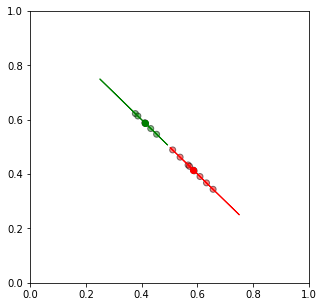

0.1624236352383016
-0.1624236352383016
{0: 0.5842147914881977, 1: 0.4124236352383016}
{0: 0.75, 1: 0.25}


In [ ]:
import copy

old_centroids = copy.deepcopy(centroids)

def update(k):
    for i in centroids.keys():
        centroids[i] = final_table[final_table['closest'] == i]['HEALTH'].mean()
    return k

centroids = update(centroids)
    
fig = plt.figure(figsize=(5, 5))
ax = plt.axes()
plt.scatter(final_table['HEALTH'], final_table['ECONOMY'], color=final_table['color'], alpha=0.5, edgecolor='k')
for i in centroids.keys():
    plt.scatter(centroids[i], 1 - centroids[i], color=colmap[i])

plt.xlim(0, 1)
plt.ylim(0, 1)

for i in old_centroids.keys():
    old_x = old_centroids[i]
    old_y = 1 - old_centroids[i]
    dx = (centroids[i] - old_centroids[i])
    dy = ((1-centroids[i]) - (1-old_centroids[i]))
    ax.arrow(old_x, old_y, dx, dy, head_width=0.0025, head_length=(np.sqrt(dx**2+dy**2)/2), fc=colmap[i], ec=colmap[i])
plt.show()

print(dx)
print(dy)

print(centroids)
print(old_centroids)

re-run clustering around new centeroids

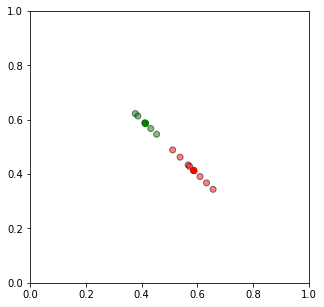

In [ ]:
final_table = assignment(final_table, centroids)

# Plot results
fig = plt.figure(figsize=(5, 5))
plt.scatter(final_table['HEALTH'], final_table['ECONOMY'], color=final_table['color'], alpha=0.5, edgecolor='k')
for i in centroids.keys():
    plt.scatter(centroids[i], 1-centroids[i], color=colmap[i])
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.show()

repeat above steps until stablized

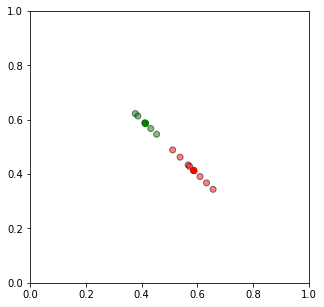

{0: 0.5842147914881977, 1: 0.4124236352383016}
There are Economy focused countries:  7
There are Health focused countries:  9
The Economy focused countries are:  ['CE', 'CH', 'JA', 'NI', 'SF', 'TH', 'ZI']
The Health focused countries are:  ['AS', 'CA', 'IN', 'IS', 'MY', 'NZ', 'PK', 'UK', 'US']


In [ ]:
# Continue until all assigned categories don't change any more
while True:
    closest_centroids = final_table['closest'].copy(deep=True)
    centroids = update(centroids)
    final_table = assignment(final_table, centroids)
    if closest_centroids.equals(final_table['closest']):
        break

fig = plt.figure(figsize=(5, 5))
plt.scatter(final_table['HEALTH'], final_table['ECONOMY'], color=final_table['color'], alpha=0.5, edgecolor='k')
for i in centroids.keys():
    plt.scatter(centroids[i], 1 - centroids[i], color=colmap[i])
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()
print(centroids)


print("There are Economy focused countries: ", len(final_table[final_table.color == 'g']))
print("There are Health focused countries: ", len(final_table[final_table.color == 'r']))

print("The Economy focused countries are: ", final_table[final_table.color == 'g'].Country.to_list())
print("The Health focused countries are: ", final_table[final_table.color == 'r'].Country.to_list())

# Recorded Clusters by month

## Jan


*   {0: 0.5842147914881977, 1: 0.4124236352383016}
*   There are Economy focused countries:  7
*   There are Health focused countries:  9
*   The Economy focused countries are:  ['CE', 'CH', 'JA', 'NI', 'SF', 'TH', 'ZI']
*   The Health focused countries are:  ['AS', 'CA', 'IN', 'IS', 'MY', 'NZ', 'PK', 'UK', 'US']

## Feb



*   {0: 0.596009348805947, 1: 0.40426205864096104}
*   There are Economy focused countries:  4
*   There are Health focused countries:  13
*   The Economy focused countries are:  ['JO', 'NI', 'SF', 'ZI']
*   The Health focused countries are:  ['AS', 'CA', 'CH', 'EI', 'IN', 'IS', 'JA', 'MY', 'NZ', 'PK', 'TH', 'UK', 'US']


## March

*   {0: 0.6948880714173015, 1: nan}
*   There are Economy focused countries:  0
*   There are Health focused countries:  15
*   The Economy focused countries are:  []
*   The Health focused countries are:  ['AS', 'CA', 'CH', 'EI', 'IN', 'IS', 'KE', 'NI', 'NZ', 'RP', 'SF', 'TH', 'UK', 'US', 'ZI']




## April



*   {0: 0.6901240008860802, 1: nan}
*   There are Economy focused countries:  0
*   There are Health focused countries:  17
*   The Economy focused countries are:  []
*   The Health focused countries are:  ['AS', 'CA', 'CH', 'EI', 'FR', 'IN', 'IS', 'MY', 'NI', 'NZ', 'PK', 'RP', 'SF', 'TH', 'UK', 'US', 'ZI']



## May



*   {0: 0.6603798425223262, 1: nan}
*   There are Economy focused countries:  0
*   There are Health focused countries:  20
*   There are Health focused countries:  20
*   The Economy focused countries are:  []
*   The Health focused countries are:  ['AS', 'CA', 'CH', 'EI', 'GH', 'IN', 'IS', 'JA', 'KE', 'MY', 'NI', 'NZ', 'PK', 'RP', 'RS', 'SF', 'TH', 'UK', 'US', 'ZI']